# Initial Data Analysis for 3A

First, the necesary imports. 
If Matplotlib does not want to display plots, install a GUI backend such as pyqt5 (available over pip) or tkinter.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
from statistics import median
from Preprocessing.relief import relief
from scipy.stats import f_oneway, zscore
np.random.seed(1234)

In [2]:
plt.rcParams['figure.figsize'] = [10, 7] # Change the desired figure size here if it is needed

Replace the following paths with the paths of the data.csv and labels.csv file on your system.

In [3]:
df = pd.read_csv("./data/raw_data/data.csv", header= None)
labels = pd.read_csv("./data/raw_data/labels.csv", header=None)

We extract the indices of the two present classes for later

In [4]:
indices_class_1 = labels.index[labels[0] == 1]
indices_class_2 = labels.index[labels[0] == 2]

Let's take a look at the ranges of the various features to see if they are comparable (relevant for kNN)

In [5]:
ranges = [max(df[i]) - min(df[i]) for i in range(0, df.shape[1])]
print(f"Max range of a feature at feature {np.argmax(ranges)}, range: {max(ranges)}")
print(f"Min range of a feature at feature {np.argmin(ranges)}, range: {min(ranges)}")
print(f"Median range: {median(ranges)}")

Max range of a feature at feature 147, range: 236.18113
Min range of a feature at feature 148, range: 0.05921000000000001
Median range: 0.391575


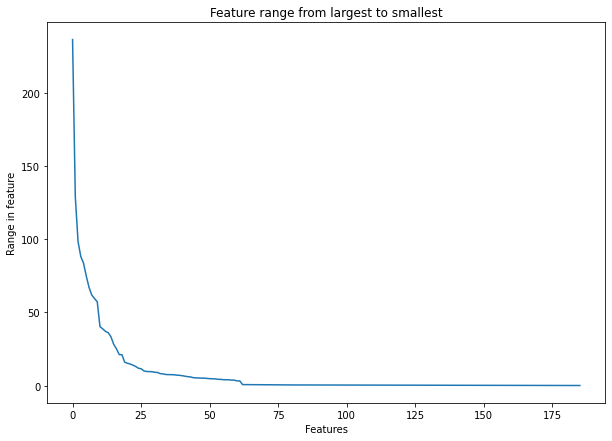

In [6]:
plt.plot(sorted(ranges, reverse=True))
plt.xlabel("Features")
plt.ylabel("Range in feature")
plt.title("Feature range from largest to smallest")
plt.show()

Next, we take a look at how the classes are balanced in the dataset.

1    156
2     23
Name: 0, dtype: int64


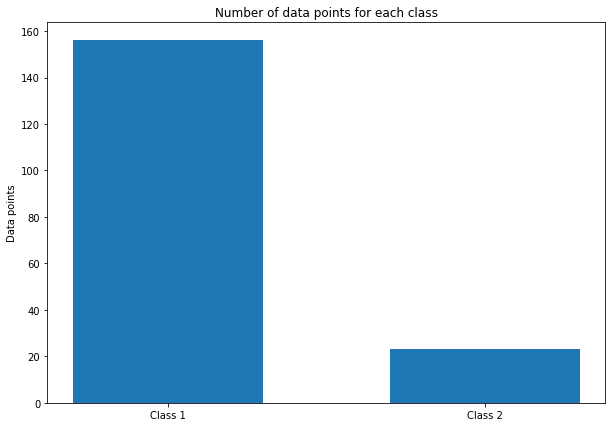

In [7]:
balance = labels[0].value_counts()
print(balance)
y_pos = np.arange(2)
plt.bar(y_pos, [balance[1], balance[2]], width=0.6)
plt.xticks(y_pos, ("Class 1", "Class 2"))
plt.ylabel("Data points")
plt.title("Number of data points for each class")
plt.show()

Unfortunately, it seems the dataset is quite unbalanced.

## PCA

Next, we'll try an exploratory PCA to see how the PCs relate to the explained variance.

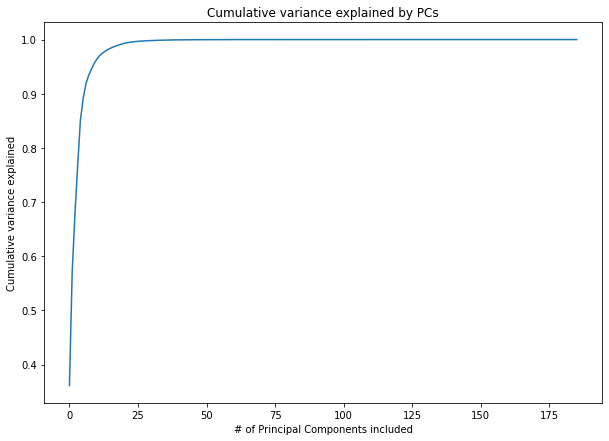

In [8]:
pca = PCA(n_components=df.shape[1])
pca.fit(df)
cum_explained = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cum_explained)
plt.xlabel("# of Principal Components included")
plt.ylabel("Cumulative variance explained")
plt.title("Cumulative variance explained by PCs")
plt.show()

Neat, it seems like PCA works relatively well. How well?

In [9]:
print("PCs needed to explain variance:")
print(f">=90% of variance explained at PC: {np.argmax(cum_explained>=0.9)}")
print(f">=95% of variance explained at PC: {np.argmax(cum_explained>=0.95)}")
print(f">=99% of variance explained at PC: {np.argmax(cum_explained >= 0.99)}")

PCs needed to explain variance:
>=90% of variance explained at PC: 6
>=95% of variance explained at PC: 9
>=99% of variance explained at PC: 19


Lets restrict the number of dimensions to 3 for visualization

Variance explained by the first 3 PCs: 0.6766136653963096


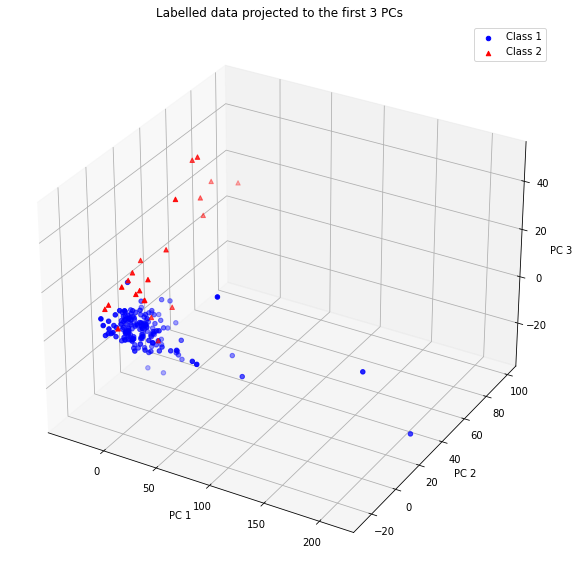

In [10]:
pca3 = PCA(n_components=3)
pca3.fit(df)
data_pca3 = pd.DataFrame(pca3.transform(df))

print(f"Variance explained by the first 3 PCs: {sum(pca3.explained_variance_ratio_)}")

plt.rcParams['figure.figsize'] = [14, 10]

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

points_class_1 = data_pca3.iloc[indices_class_1]
points_class_2 = data_pca3.iloc[indices_class_2]

ax.scatter(points_class_1[0], points_class_1[1], points_class_1[2], color='b', marker='o', label="Class 1")
ax.scatter(points_class_2[0], points_class_2[1], points_class_2[2], color='r', marker='^', label="Class 2")

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.set_title("Labelled data projected to the first 3 PCs")
plt.legend()
plt.show()

One last interesting visualisation is to see how the data from the unlabelled set is distributed over this space.

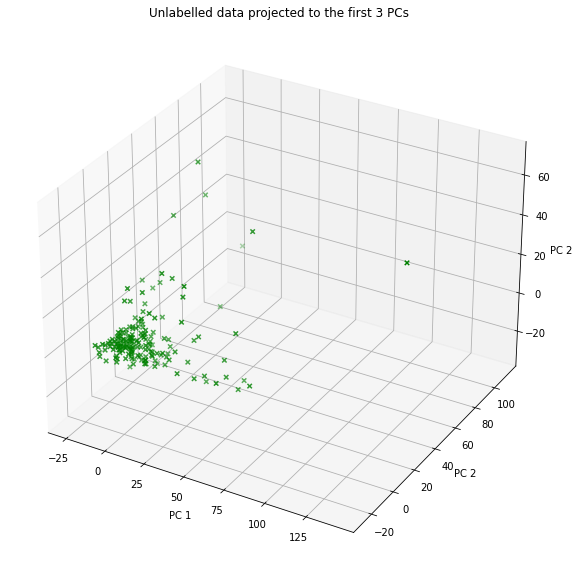

In [11]:
unlabelled_data = data_pca3.iloc[labels.shape[0]:, :]

plt.rcParams['figure.figsize'] = [14, 10]
fig = plt.figure()
ax = fig.add_subplot(projection="3d")

ax.scatter(unlabelled_data[0], unlabelled_data[1], unlabelled_data[2], color='g', marker = 'x')

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 2")
ax.set_title("Unlabelled data projected to the first 3 PCs")
plt.show()

## ANOVA

We will perform anova for each feature, and see which features differ the most between groups.

In [12]:
pvals = []

dps_c1 = df.iloc[indices_class_1]
dps_c2 = df.iloc[indices_class_2]

for feature_idx in range(df.shape[1]):
    c1_feature = dps_c1.iloc[:, feature_idx]
    c2_feature = dps_c2.iloc[:, feature_idx]
    
    f = f_oneway(c1_feature, c2_feature)
    pvals.append(f.pvalue)
    

feature_indices = list(range(df.shape[1]))

sorted_pvals, sorted_feature_indices = zip(*sorted(zip(pvals, feature_indices)))

Lets see how many of these features return a significant difference.

In [13]:
num_significant = sum(v < 0.05 for v in sorted_pvals)
print(num_significant)

114


Quite a lot. What if we check for a lower p-value (*** level)?

In [14]:
num_significant = sum(v < 0.001 for v in sorted_pvals)
print(num_significant)

73


Still quite a few. For visualisation, we will show the first 10 or so.

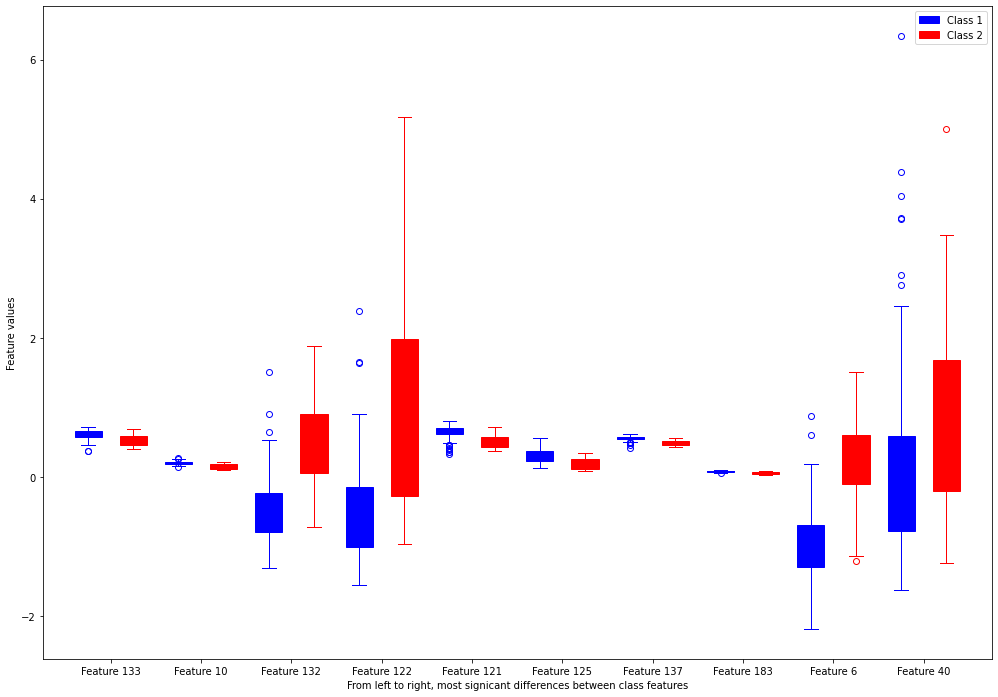

In [15]:
data_best_anova_1 = []
data_best_anova_2 = []
for i in range(10):
    data_best_anova_1.append(dps_c1[feature_indices[i]])
    data_best_anova_2.append(dps_c2[feature_indices[i]])

# We change the size due to all the data
plt.rcParams['figure.figsize'] = [17, 12]
    
c = "blue"
plt.boxplot(data_best_anova_1, positions=list(range(1,11)), widths=0.3, patch_artist=True, 
            boxprops=dict(facecolor=c, color=c), capprops=dict(color=c),
            whiskerprops=dict(color=c), flierprops=dict(color=c, markeredgecolor=c), medianprops=dict(color=c))

c = "red"
plt.boxplot(data_best_anova_2, positions=[0.5 + i for i in range(1, 11)], widths=0.3, patch_artist=True, 
            boxprops=dict(facecolor=c, color=c), capprops=dict(color=c),
            whiskerprops=dict(color=c), flierprops=dict(color=c, markeredgecolor=c), medianprops=dict(color=c))

y_pos = [0.25 + i for i in range(1, 11)]
plt.xticks(y_pos, [f"Feature {i}" for i in sorted_feature_indices[:10]])

plt.ylabel("Feature values")
plt.xlabel("From left to right, most signicant differences between class features")

#Custom legend as matplotlib does not support labelling the way I'd like
legend_els = [Patch(facecolor='b', edgecolor='b', label='Class 1'), 
                Patch(facecolor='r', edgecolor='r',label='Class 2')]


plt.legend(handles=legend_els, loc="best")

    
plt.show()

# T-SNE 

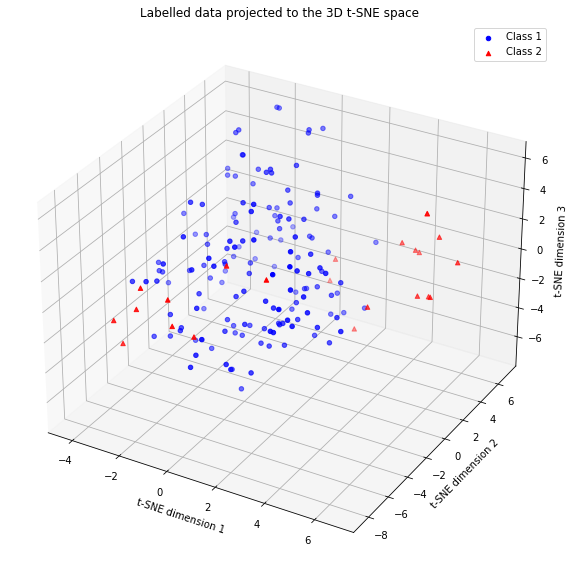

In [16]:
# We define a function as we do t-SNE a lot later on. It depends on variables that are global in this
# document. Not good practice, but I suppose fine for an exploratory document.

def plot_tsne3d(data: pd.DataFrame, title: str):
    plt.rcParams['figure.figsize'] = [14, 10]
    
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    
    points_class_1 = tsne.iloc[indices_class_1]
    points_class_2 = tsne.iloc[indices_class_2]
    ax.scatter(points_class_1[0], points_class_1[1], points_class_1[2], color='b', marker='o', label="Class 1")
    ax.scatter(points_class_2[0], points_class_2[1], points_class_2[2], color='r', marker='^', label="Class 2")
    
    ax.set_xlabel("t-SNE dimension 1")
    ax.set_ylabel("t-SNE dimension 2")
    ax.set_zlabel("t-SNE dimension 3")
    ax.set_title(title)
    plt.legend()
    plt.show()

tsne = pd.DataFrame(TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(df))
plot_tsne3d(tsne, "Labelled data projected to the 3D t-SNE space")


It seems that T-SNE can separate these points relatively well, in two islands.

# Impact of pre-processing methods

In this section we will evaluate the effect of various methods of pre-processing on the ability to separate the data using t-SNE. 

## Pre-processing without upsampling

### PCA with 9 leading eigenvectors ($\geq$95% of variance explained)

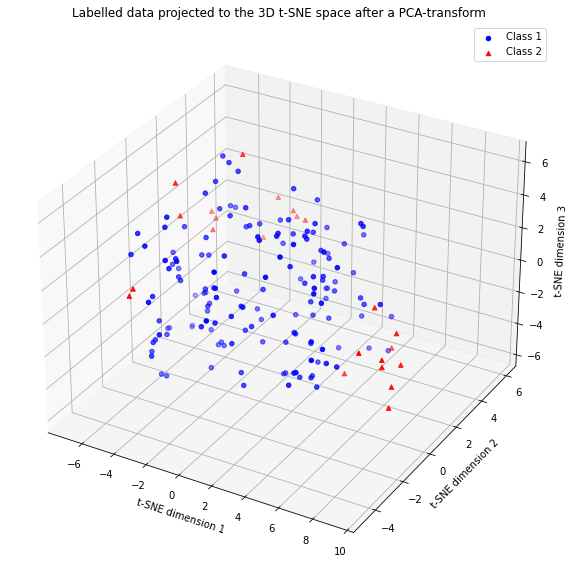

In [17]:
pca9 = PCA(n_components=9)
data_pca9 = pd.DataFrame(pca9.fit_transform(df))

tsne = pd.DataFrame(TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(data_pca9))
plot_tsne3d(tsne, "Labelled data projected to the 3D t-SNE space after a PCA-transform")

It seems like the separation is slightly better, the red points have been projected much more outward.

### Z-Transformed data

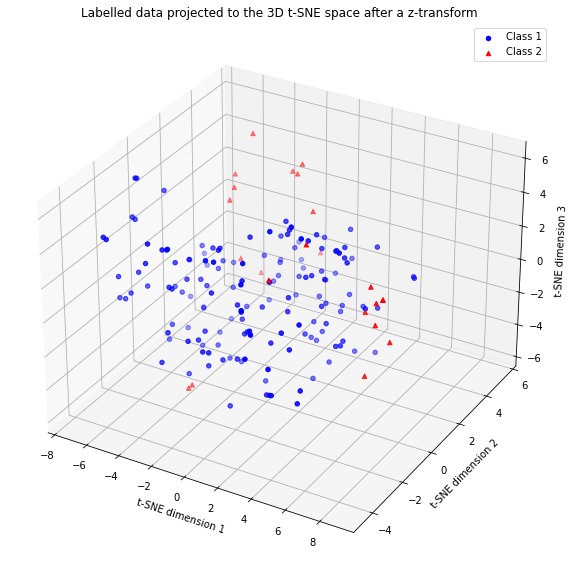

In [18]:
df2 = df.copy()
df2.apply(zscore)

tsne = pd.DataFrame(TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(df2))
plot_tsne3d(tsne, "Labelled data projected to the 3D t-SNE space after a z-transform")

### Feature selection using ANOVA
We have previously found which features differ the most significantly according to ANOVA. So perhaps we can only use those for t-SNE? As above, we'll use the features whose difference in means was at least of a significance level ***.

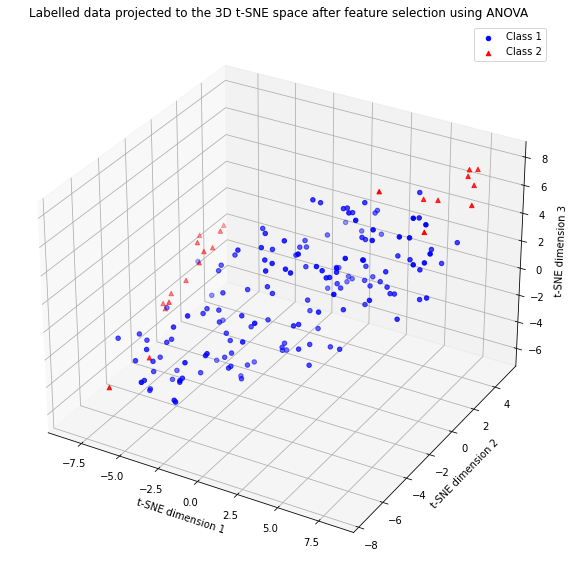

In [19]:
df2 = df.iloc[:,list(sorted_feature_indices[:73])]

tsne = pd.DataFrame(TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(df2))
plot_tsne3d(tsne, "Labelled data projected to the 3D t-SNE space after feature selection using ANOVA")

### Feature selection using Relief
We use a self-written relief function to perform the relief algorithm and then we analyse the results.
Minor precaution: This makes your computer work somewhat, so don't worry if it does not finish for a while.

In [27]:
w = relief(df, labels, labels.shape[0])
print(f"Most relevant weight: {max(w)}")
print(f"Median weight: {median(w)}")

sorted_weights, sorted_feature_weight_indices = zip(*sorted(zip(w, list(range(df.shape[1]))), reverse=True))

comp = pd.DataFrame()
comp['most_relevant_features_relief'] = sorted_feature_weight_indices[:10]
comp['most_relevant_features_ANOVA'] = sorted_feature_indices[:10]

comp

Most relevant weight: 0.31969406721239246
Median weight: 0.038423435903970835


,most_relevant_features_relief,most_relevant_features_ANOVA
0,167,133
1,163,10
2,40,132
3,162,122
4,133,121
5,160,125
6,31,137
7,36,183
8,35,6
9,156,40


Interestingly, there are only 2 features in common between the two methods in the top 10. Let's try t-SNE using only these dimensions.

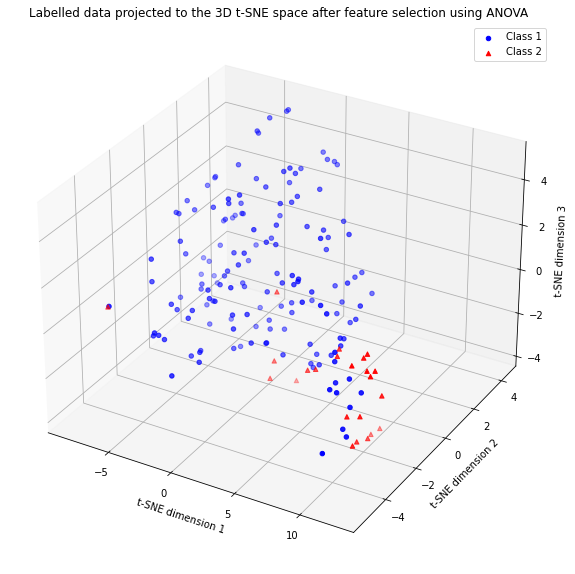

In [31]:
df2 = df.iloc[:,list(sorted_feature_weight_indices[:10])]

tsne = pd.DataFrame(TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(df2))
plot_tsne3d(tsne, "Labelled data projected to the 3D t-SNE space after feature selection using Relief")

What if we combine these top 10s?

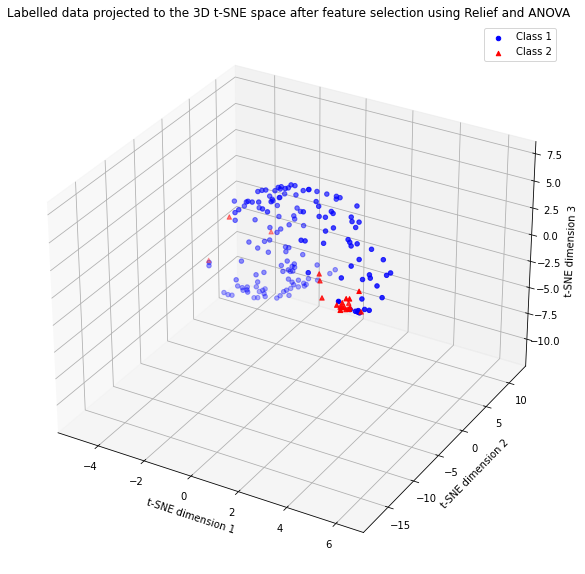

In [34]:
indices = list(set(sorted_feature_weight_indices[:10]).union(set(sorted_feature_indices[:10])))
df2 = df.iloc[:,indices]

tsne = pd.DataFrame(TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(df2))
plot_tsne3d(tsne, "Labelled data projected to the 3D t-SNE space after feature selection using Relief and ANOVA")

## Pre-processing after upsampling